In [1]:
# 라이브러리 부르기
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from tqdm.auto import tqdm
import concurrent.futures
import functools

In [ ]:
pip install -q -U tensorboard

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

input_PATH = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img/'
label_PATH = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/'
test_PATH = '/content/gdrive/MyDrive/dacon_camera/data/test_input_img/'

In [4]:
# 이미지 로드 함수
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  image = tf.cast(image, tf.float32)

  return image

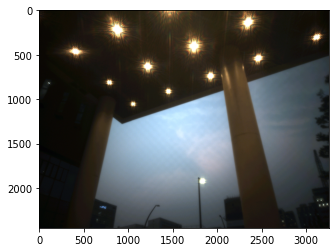

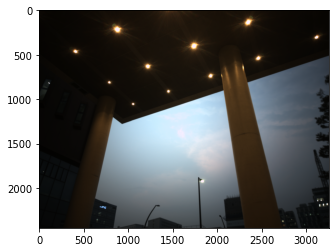

In [5]:
inp = load(input_PATH + 'train_input_10060.png')
re = load(label_PATH + 'train_label_10060.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
SAVE_TRAIN_INPUT_PATH = './data/train_input_img_'
SAVE_TRAIN_LABEL_PATH = './data/train_label_img_'

SAVE_VAL_INPUT_PATH = './data/val_input_img_'
SAVE_VAL_LABEL_PATH = './data/val_label_img_'

IMG_SIZE = 256

In [8]:
os.makedirs(f'{SAVE_TRAIN_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_TRAIN_LABEL_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_LABEL_PATH}{IMG_SIZE}', exist_ok=True)

In [9]:
def cut_img(save_path, img_path):    
    img = cv2.imread(img_path)
    img_name = os.path.basename(img_path)
    num = 0
    for top in range(0, img.shape[0], STRIDE):
        for left in range(0, img.shape[1], STRIDE):
            piece = np.zeros([IMG_SIZE, IMG_SIZE, 3], np.uint8)
            temp = img[top:top+IMG_SIZE, left:left+IMG_SIZE, :]
            piece[:temp.shape[0], :temp.shape[1], :] = temp
            cv2.imwrite(f'{save_path}{IMG_SIZE}/{num}_{img_name}', piece)            
            # np.save(f'{save_path}{img_size}/{num}.npy', piece)                
            num+=1
    return

In [10]:
train_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/train.csv')
test_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/test.csv')

train_all_input_files = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img/'+train_csv['input_img']
train_all_label_files = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/'+train_csv['label_img']
# 파일이름 + 경로

train_input_files = train_all_input_files[60:]
train_label_files = train_all_label_files[60:]
#테스트용

val_input_files = train_all_input_files[:60]
val_label_files = train_all_label_files[:60]
#검증용

In [12]:
STRIDE = 256

with concurrent.futures.ProcessPoolExecutor() as executor: # windows local 환경시 max_workers=os.cpu_count()//2
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_INPUT_PATH), train_input_files),             
        desc='train input image cut',
        total=len(train_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_LABEL_PATH), train_label_files),             
        desc='train label image cut',
        total=len(train_label_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_INPUT_PATH), val_input_files),             
        desc='val input image cut',
        total=len(val_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_LABEL_PATH), val_label_files),             
        desc='val label image cut',
        total=len(val_label_files)
    ))

In [13]:
train_inp_files = glob(f'./data/train_input_img_256/*.png')
train_targ_files = glob(f'./data/train_label_img_256/*.png')

val_inp_files = glob(f'./data/val_input_img_256/*.png')
val_targ_files = glob(f'./data/val_label_img_256/*.png')

In [14]:
print(len(train_inp_files), len(train_targ_files), len(val_inp_files), len(val_targ_files), type(train_inp_files))

39810 39810 7800 7800 <class 'list'>


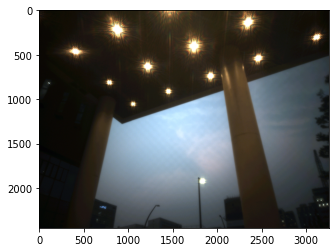

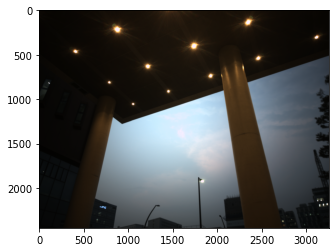

In [15]:
inp_256 = load('./data/train_input_img_256/0_train_input_10060.png')
re_256 = load('./data/train_label_img_256/0_train_label_10060.png')

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [16]:
# 전처리 유틸 함수

def resize(image, height, width):
  image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return image

In [17]:
# normalizing the images to [-1, 1]

def normalize(image):
  image = (image / 127.5) - 1

  return image

In [18]:
# 통합 전처리 함수

@tf.function()
def preprocess(image) :

    #resize
    image = resize(image, 256, 256)

    #augmentation 생략

    return image

In [19]:
# 데이터 불러오기

def load_image_train(image_file):
  image = load(image_file)
  image = preprocess(image)
  image = normalize(image)

  return image

def load_image_test(image_file):
  image = load(image_file)
  image = resize(image, IMG_HEIGHT, IMG_WIDTH)
  image = normalize(image)

  return image

In [20]:
train_input_dataset = tf.data.Dataset.list_files(SAVE_TRAIN_INPUT_PATH+'256/*.png')
train_input_dataset = train_input_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_input_dataset = train_input_dataset.shuffle(BUFFER_SIZE)
train_input_dataset = train_input_dataset.batch(BATCH_SIZE)

train_label_dataset = tf.data.Dataset.list_files(SAVE_TRAIN_LABEL_PATH+'256/*.png')
train_label_dataset = train_label_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_label_dataset = train_label_dataset.shuffle(BUFFER_SIZE)
train_label_dataset = train_label_dataset.batch(BATCH_SIZE)


val_input_dataset = tf.data.Dataset.list_files(SAVE_VAL_INPUT_PATH+'256/*.png')
val_input_dataset = val_input_dataset.map(load_image_test)
val_input_dataset = val_input_dataset.batch(BATCH_SIZE)

val_label_dataset = tf.data.Dataset.list_files(SAVE_VAL_LABEL_PATH+'256/*.png')
val_label_dataset = val_label_dataset.map(load_image_test)
val_label_dataset = val_label_dataset.batch(BATCH_SIZE)

train_input_dataset.element_spec, train_label_dataset.element_spec, val_input_dataset.element_spec, val_label_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))

In [21]:
# 3. Generator 생성
# 인코더 부분

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
# 디코더 부분

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [23]:
# Gernerator 생성

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

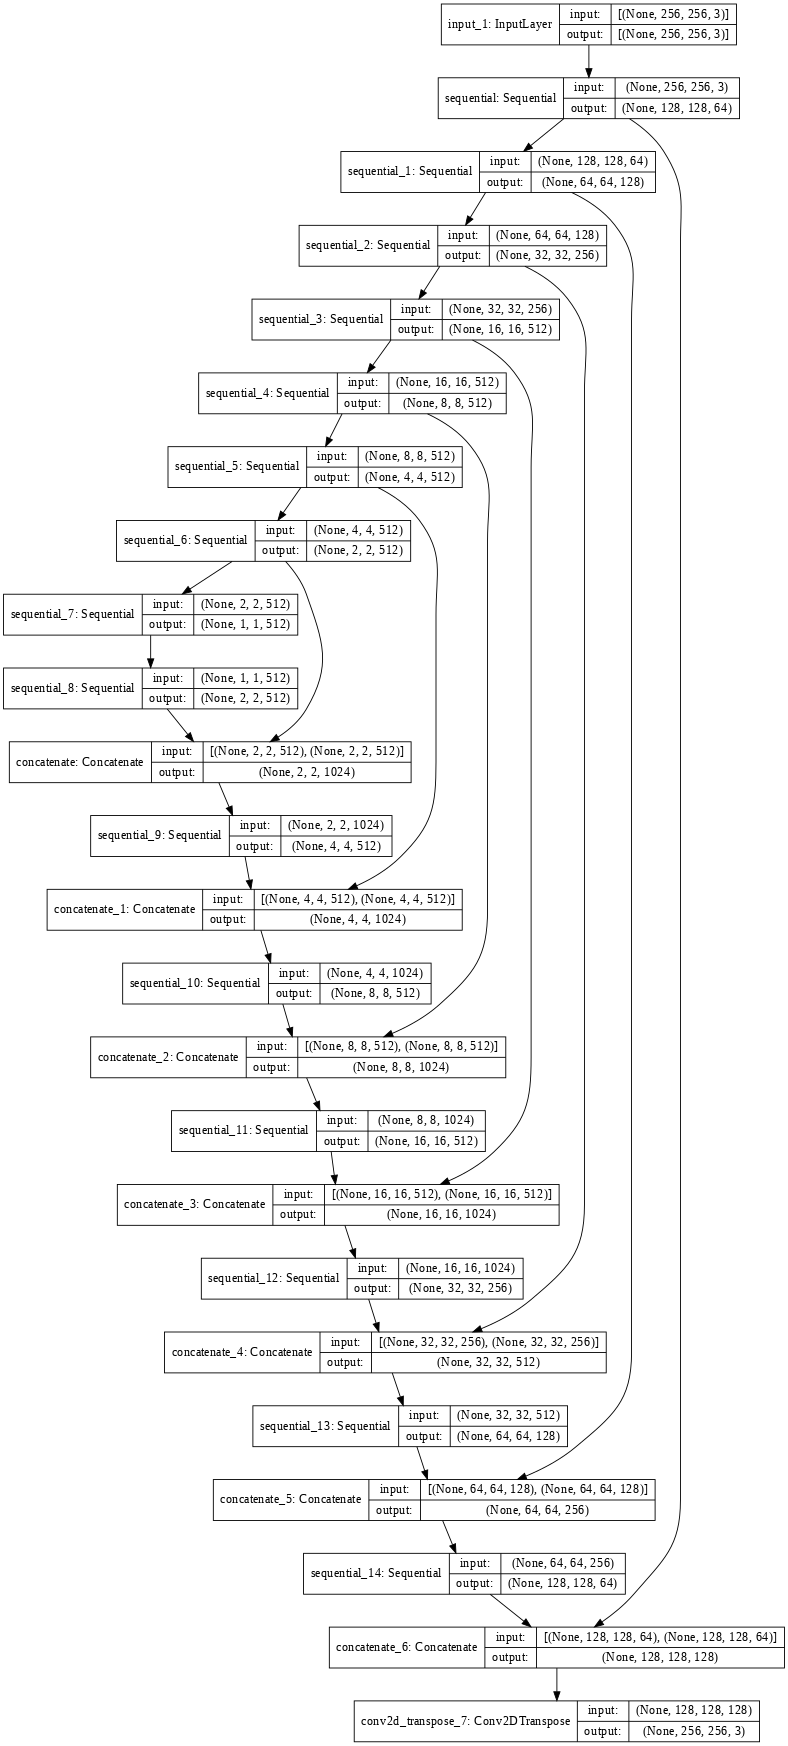

In [24]:
# 모델 구조 확인

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [25]:
# Generator 손실 함수

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [26]:
# 4. Discriminator 생성

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

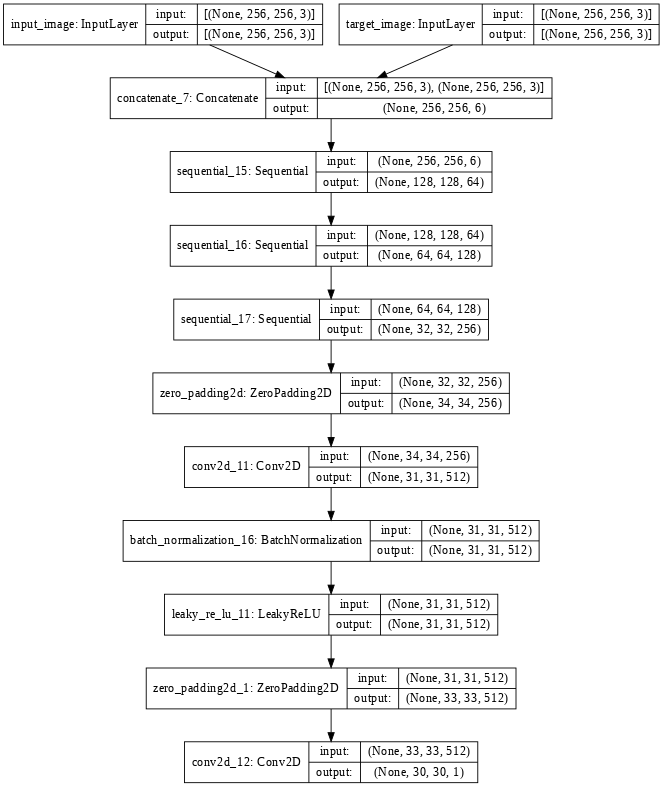

In [27]:
# 모델 구조 확인

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [28]:
# Discriminator 손실

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [29]:
# 5. 준비
# 옵티마이저 설정

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
# 체크포인트 기능

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
# 이미지 생성 유틸

def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [32]:
# 6. 훈련 준비

EPOCHS = 30

import datetime
log_dir="./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [33]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    print(gen_output.shape)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [34]:
def fit(train_input_ds, train_label_ds, epochs, val_input_ds, val_label_ds):
  for epoch in range(epochs):
    start = time.time()


    #for example_input in zip(val_input_ds, val_label_ds).take(1):
    #  generate_images(generator, example_input)
    print("Epoch: ", epoch)

    # Train
    n = 0
    for input_image, target in zip(train_input_ds, train_label_ds):
      if (n+1) % 100 == 0:
        print('.')
      print()
      train_step(input_image, target, epoch)
      n += 1
    n=0
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
# 7. 훈련 시작
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}
import time

fit(train_input_dataset, train_label_dataset, EPOCHS, val_input_dataset, val_label_dataset)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

























































































.




































































































.




































































































.




































































































.




































































































.




































































































.




































































































.




































































































.




































































































.

























































